# FalconCV

FalconCV is an open-source python library that offers developers an interface to interact with some of the most popular computer vision frameworks, such as Tensorflow Object detection API and Detectron. The main objective behind it is to unify the set of tools available and simplify the use of them. This library is focused mainly on Computer Vision practitioners but also is flexible enough to allow researchers to configure the models at a low-level. Additionally, taking advantage of the fantastic features that OpenVINO offers, a custom model can be trained and optimized to run efficiently in the target hardware with just a few lines of code. It is important to say that FalconCV does not attempt to replace any of the tools mentioned previously; instead, it takes the best of them and offers a solution to improve accessibility to new users. FalconCV still in betha, but the test installer is here : https://test.pypi.org/project/falconcv.

## Check Tensorflow Version and GPU Support



## Install FalconCV Dependencies

In [0]:
!pip install matplotlib
!pip install numpy==1.17
!pip install opencv-contrib-python
!pip install pillow
!pip install cython
!pip install tqdm
!pip install scipy
!pip install requests 
!pip install clint
!pip install validators
!pip install more-itertools
!pip install pandas
!pip install imutils
!pip install boto3
!pip install "dask[complete]" 
!pip install lxml
!pip install Mako
!pip install colorlog
!pip install colorama
!pip install bs4
!pip install pick
!pip install -U scikit-learn
!pip install gitpython
!pip install cython
!pip install pycocotools
!pip install omegaconf
!pip install -U -f https://extras.wxpython.org/wxPython4/extras/linux/gtk3/ubuntu-16.04 wxPython
!pip install tf_slim
!sudo apt install protobuf-compiler

## Install FalconCV

In [0]:
!pip uninstall falconcv -y && pip install git+https://github.com/haruiz/FalconCV.git

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


# Imports

In [0]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from falconcv.models.tf import ModelZoo
from falconcv.ds import *
from falconcv.util import FileUtil, VIUtil, ColorUtil
from falconcv.models import ModelBuilder

images_folder = "images"
model_folder = "model"

# Util functions

In [0]:

def create_dataset(images_folder , labels_map,color_palette, n):
    try:
        # creating dataset
        dataset = Coco(v=2017)
        dataset.setup(split="train", task="segmentation")
        #labels = dataset.labels_map.values() # get valid labels
        os.makedirs(images_folder, exist_ok=True)
        FileUtil.clear_folder(images_folder)
        for batch_images in dataset.fetch(
                n=n,
                labels=list(labels_map.keys()),
                batch_size=500):
            for img in batch_images:
                img.export(images_folder, labels_map, color_palette)
                for region in img.regions:
                    pass
                    # print(region.shape_attributes["x"],
                    #       region.shape_attributes["y"])
    except Exception as ex:
        print("error creating the dataset {} ".format(ex))


def train_and_freeze_model(model_name, images_folder, out_folder, labels_map, epochs=5000):
    try:
        config = {
            "model": model_name,
            "images_folder": images_folder,
            "output_folder": out_folder,
            "labels_map": labels_map,
        }
        with ModelBuilder.build(config=config) as model:
            model.train(epochs=epochs, val_split=0.3, clear_folder=True)
            model.freeze(epochs)
    except Exception as ex:
        raise Exception("Error training the model {} ".format(ex)) from ex


def make_predictions(frozen_model, labels_map_file, image):    
    # load freeze model
    with ModelBuilder.build(frozen_model, labels_map_file) as model:
        image, predictions = model.predict(image, threshold=0.7)
        fig = VIUtil.imshow(image, predictions)
        fig.savefig('result.png', dpi=300, bbox_inches='tight')   

# Create Dataset

In [0]:
labels_map = {
    "bird": 1,
    "cat": 2
}
color_palette = ColorUtil.color_palette(n=len(labels_map))
create_dataset(images_folder, labels_map,color_palette, n=1000)

INFO     downloading file http://images.cocodataset.org/annotations/annotations_trainval2017.zip
INFO     file downloaded successfully


loading annotations into memory...
Done (t=14.34s)
creating index...
index created!


INFO     downloading images for : bird
INFO     downloading batch 1/2
INFO     downloading batch 2/2
INFO     downloading images for : cat
INFO     downloading batch 1/2
INFO     downloading batch 2/2


# Train the model

In [0]:
from pathlib import Path
#Path("/root/.falconcv/pipelines/tf").mkdir(parents=True, exist_ok=True)
print(ModelZoo.available_models(arch="mask")) # check the models available
train_and_freeze_model("mask_rcnn_inception_v2_coco",images_folder, model_folder, labels_map)

#Test the model

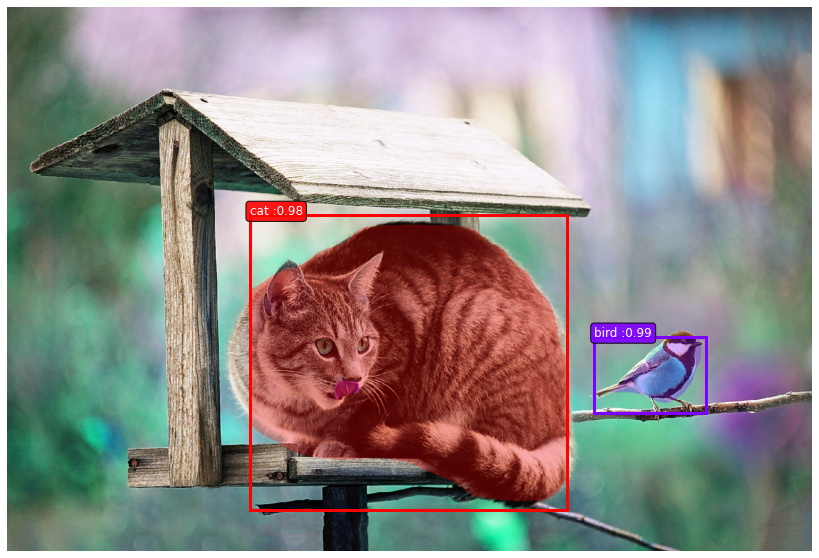

In [0]:
%matplotlib inline
image_uri = "https://s3.eu-central-1.amazonaws.com/pressland-cms/cache/__original__/bm/20290377-koty-pokonaja-wiele-przeszkod-by-upolowac-bogatke.jpeg"
frozen_model_file = os.path.join(model_folder, "export/frozen_inference_graph.pb")
labels_map_file = os.path.join(model_folder, "label_map.pbtxt")
make_predictions(frozen_model_file, labels_map_file, image_uri)